# League of Legends Performance vs Time of Day/Week

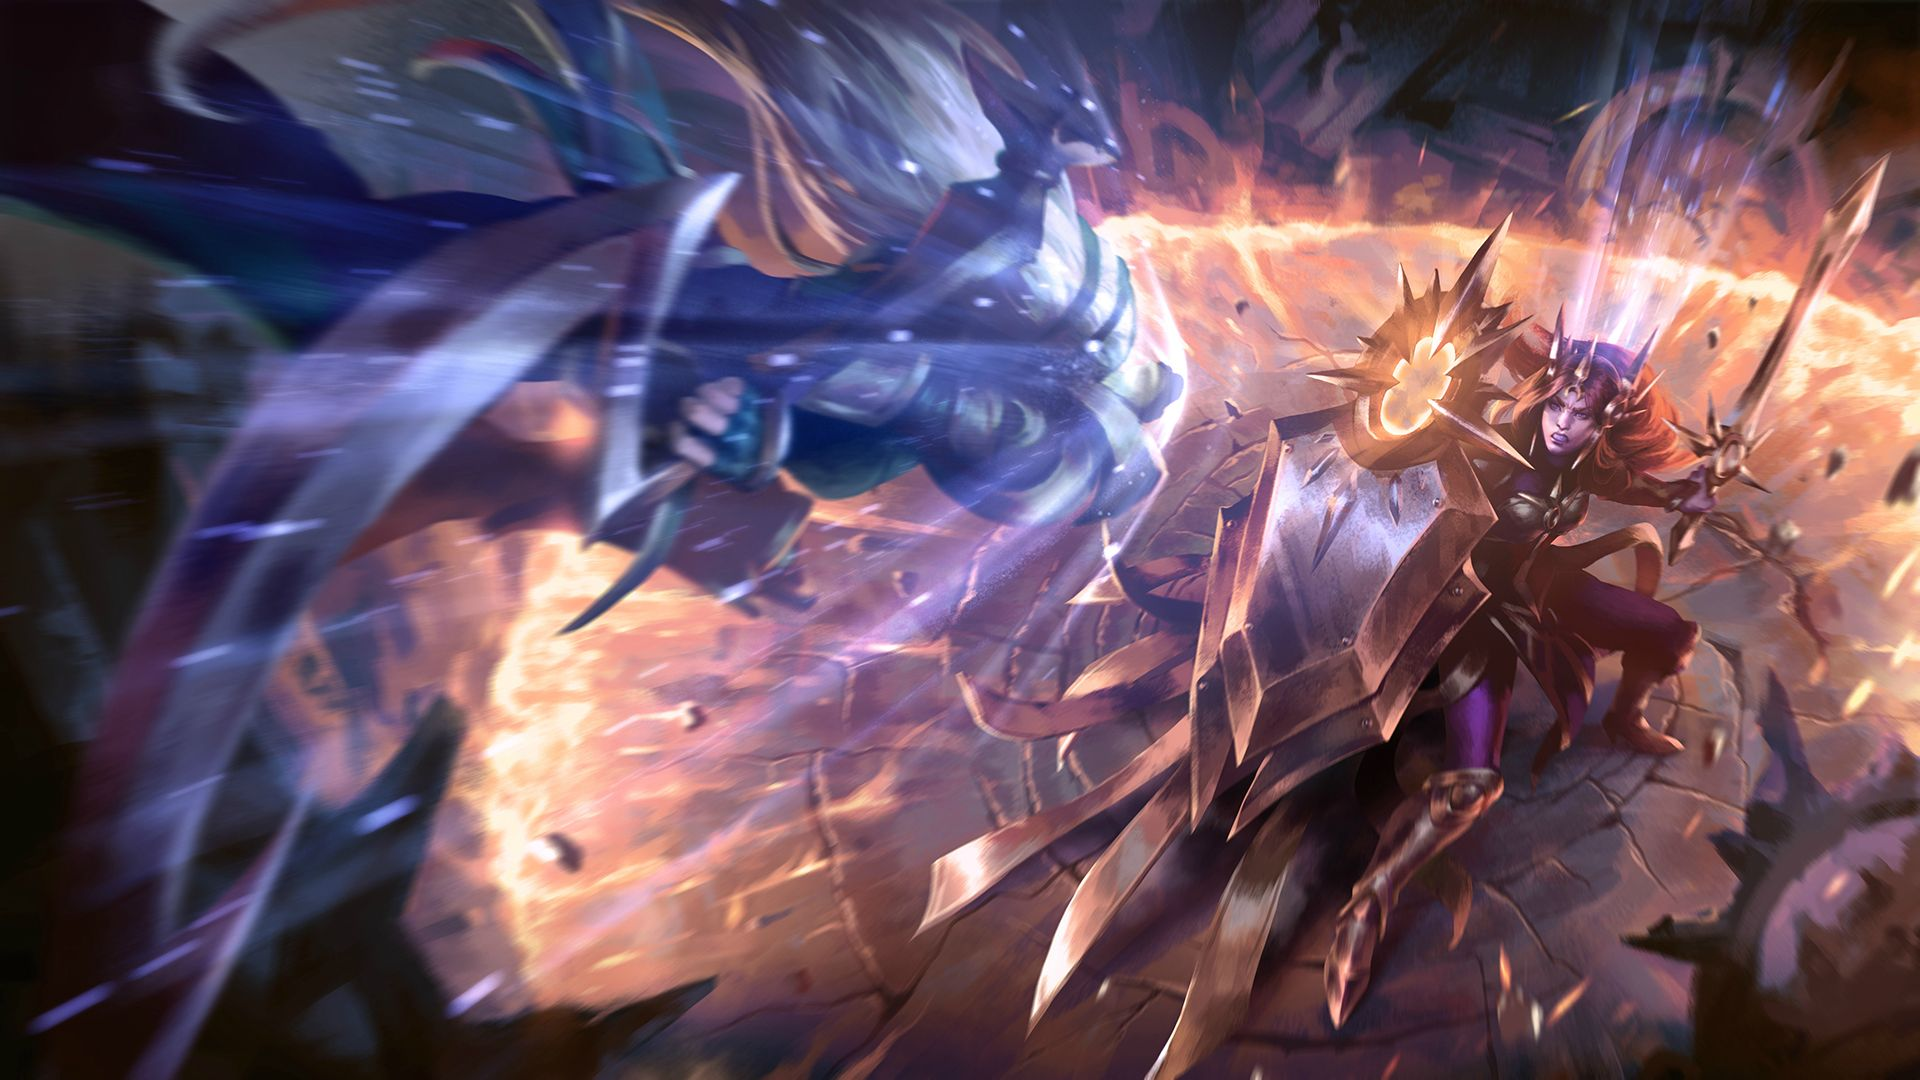

In [1]:
from IPython.display import Image # to import images
Image(filename='nightvsday.jpg')

## Introduction 

Quality performance is key for one to improve in League of Legends. 

Something that a player could do to improve gameplay performance is to practice or use analytic sites such as Mobalytics or na.op.gg.

## Mobalytics Example

Here, we take a look at a sample summoner on how they perform against similar players in their division. All skills are equal or above except aggression.

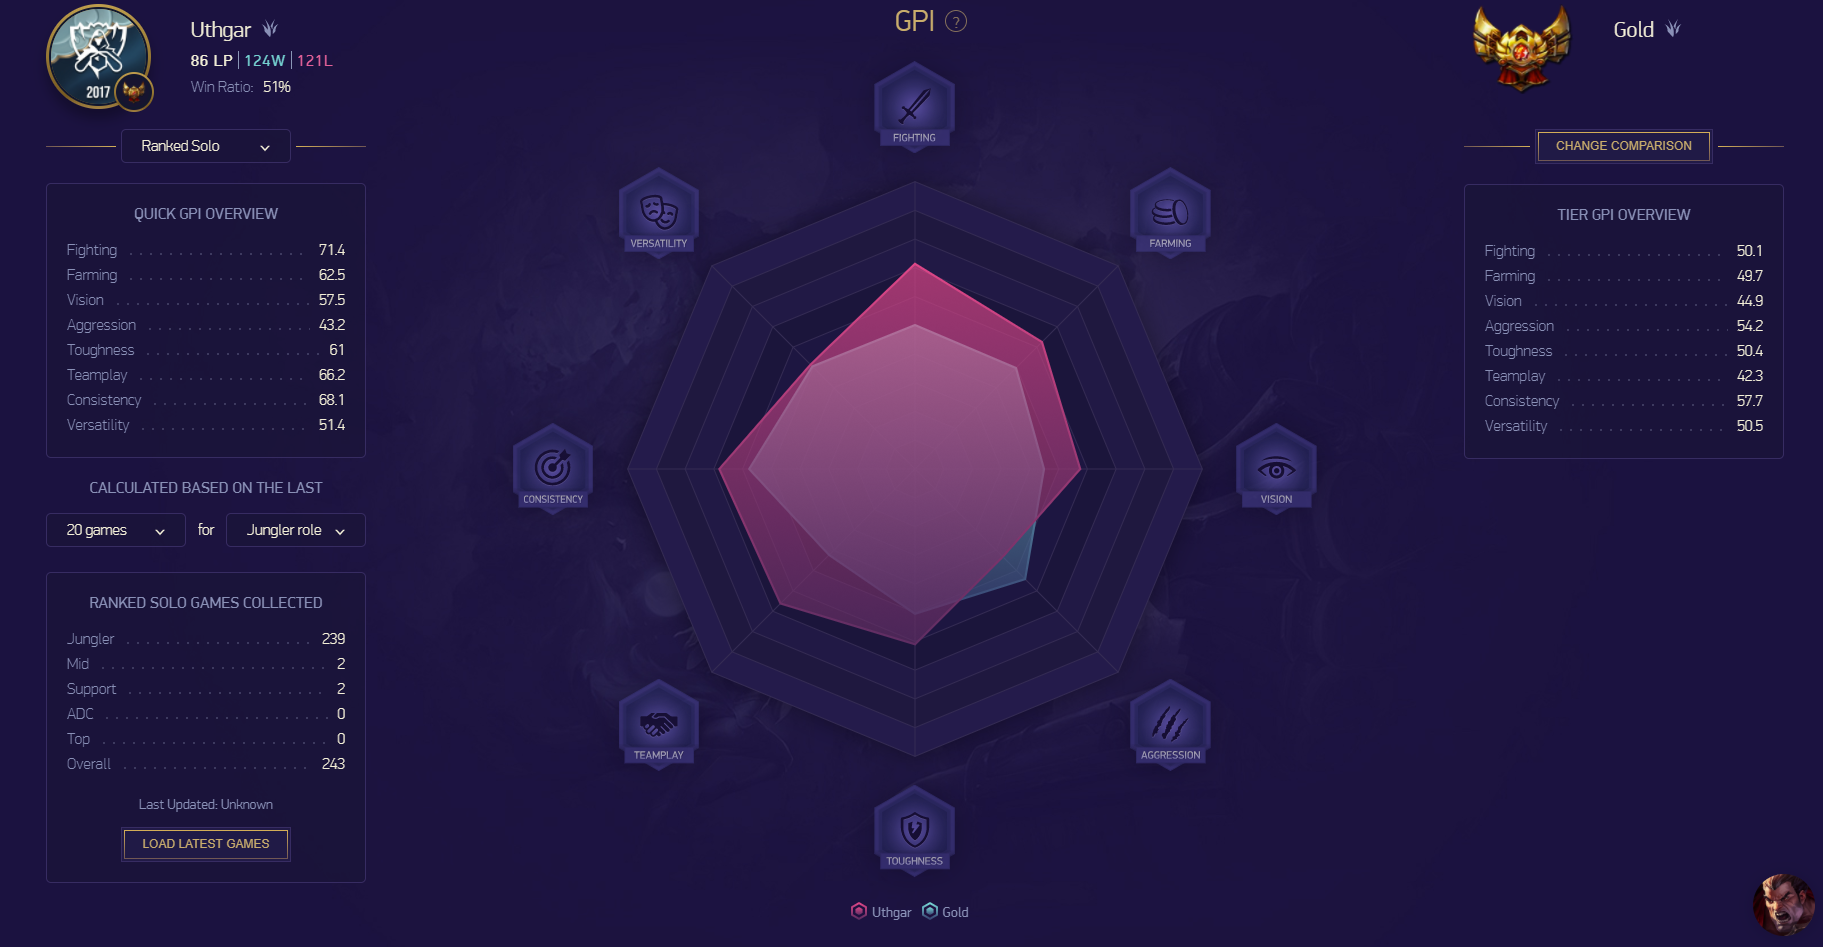

In [2]:
Image(filename='gpi.png') # GPI for Uthgar

Let's take a deeper look on how to improve aggression skill for this summoner.

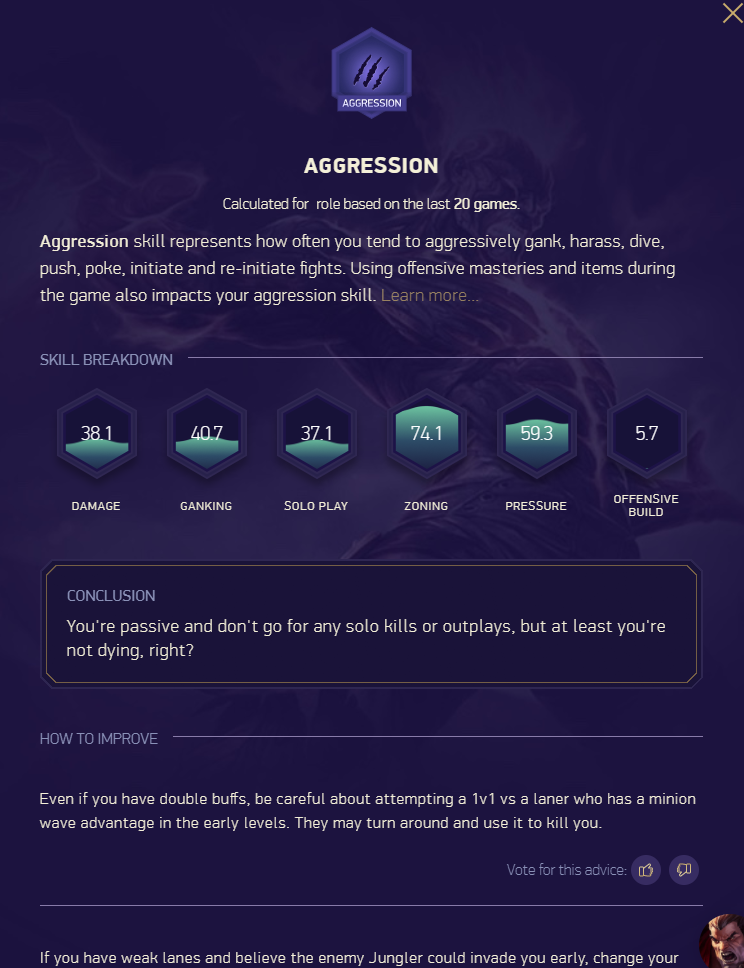

In [3]:
Image(filename='gpiaggression.png') # GPI for Aggression

## na.op.gg example

Here, we take a look at the win rate of champions in a division. The top 5 are highlighted. Playing these champions would most likely help a summoner win their game with decent performance.

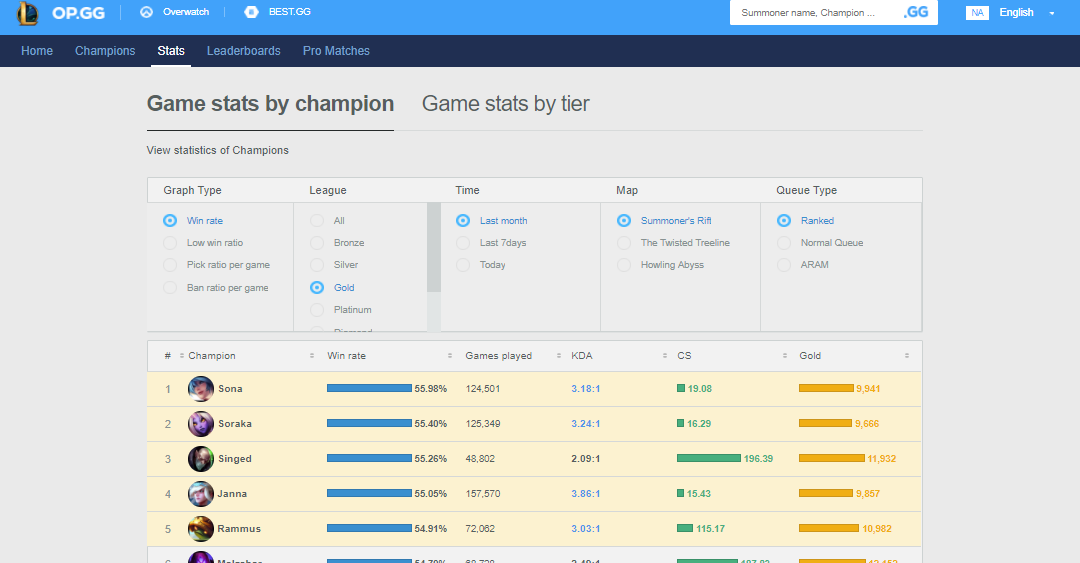

In [4]:
Image(filename='winrate.png') # Winrates for Gold Division

## Performance vs Time of Day

Something that isn't answered by many analytic sites is performance versus time of day.

For example, we all have a preferred time of day to do thing such as work, study, and sleep.

Perhaps we perform the best during the day, thus we work during that time.
Maybe we study in the afternoon since that is when or coffee has kicked in.
Also, maybe we sleep during the night since our body's performance is the weakest then.

What about gaming performance?

Do we perform the best during the day or night?
After work or before work? During work?

This quick study uses Riot's API to find out.

## Method

The method we are going to use is quick requests on Riot's API.

For this, we will need a developer API key.

Limitations to this is that the code we use will expire in a day and also we are limited to 100 requests every 2 minutes.

Thus, we will only use the past 100 games for each analysis.

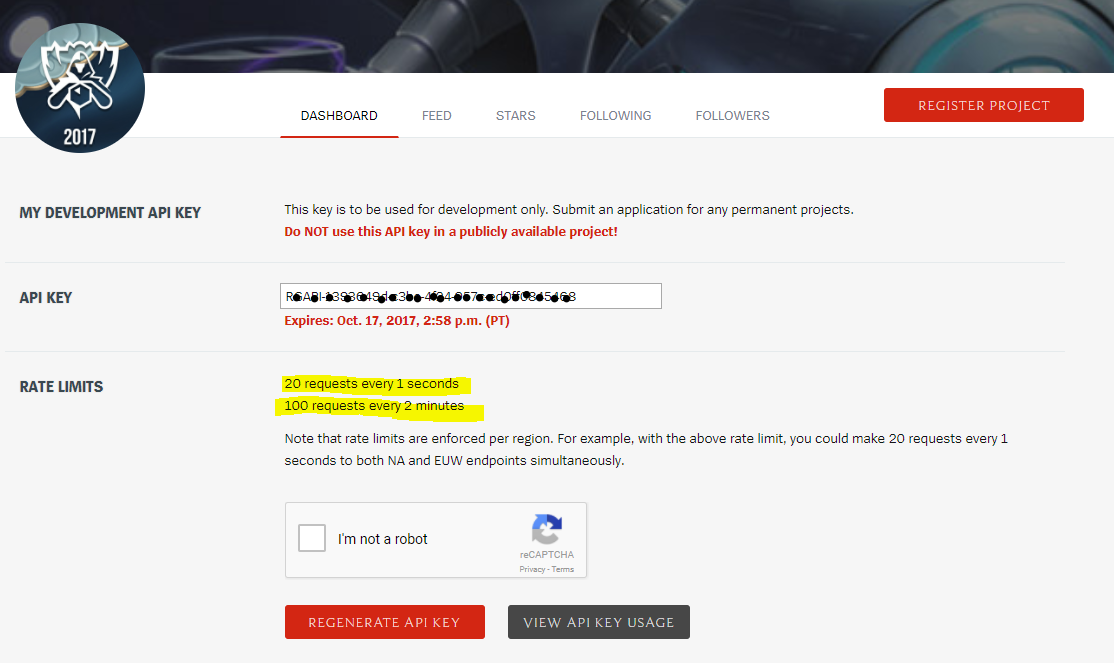

In [5]:
Image(filename='api.png') # Riot's Developer page

## Inputs

Since this analysis is done on Python, the reuseability and scalability is great.

We only need 2 things to proceed with the entire script:

- Summoner name for 'cat_id'
- API key for 'api'

In [6]:
http = "https://na1.api.riotgames.com/lol"
cat = "/summoner/v3/summoners/by-name/" 

cat_id = "uthgar" ### INPUT HERE
api = "?api_key=RGAPI-1393649d-c3be-4f24-957c-ed0ff0845468" ### INPUT HERE

h = (http + cat + cat_id + api)
h

'https://na1.api.riotgames.com/lol/summoner/v3/summoners/by-name/uthgar?api_key=RGAPI-1393649d-c3be-4f24-957c-ed0ff0845468'

In [7]:
import urllib.request, json # to read json file
with urllib.request.urlopen(h) as url:
    summoner = json.loads(url.read().decode())
summoner

{'accountId': 29896,
 'id': 3032,
 'name': 'Uthgar',
 'profileIconId': 3006,
 'revisionDate': 1508120090000,
 'summonerLevel': 30}

In [8]:
cat = "/match/v3/matchlists/by-account/" # search by account for matches
cat_id = str(summoner['accountId'])
h = (http + cat + cat_id + api)
h

'https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/29896?api_key=RGAPI-1393649d-c3be-4f24-957c-ed0ff0845468'

In [9]:
with urllib.request.urlopen(h) as url:
    matches = json.loads(url.read().decode())

In [10]:
gameIds = []
for i in matches['matches']:
    gameIds.append(i['gameId'])
time = []
kda = []
win = []

In [11]:
from time import sleep # wait for 2 minutes because of Riot's rate-limiting
sleep(120)

cat = "/match/v3/matches/"
for i in range(len(gameIds)):
    cat_id = str(gameIds[i])
    h = (http + cat + cat_id + api)
    with urllib.request.urlopen(h) as url:
        match = json.loads(url.read().decode())
    for i in match['participantIdentities']:
        if i['player']['summonerName'] == summoner['name']:
            participantId = i['participantId']
    stats = match['participants'][participantId - 1]['stats']
    time.append(match['gameCreation'])
    try:
        kda.append((stats['kills'] + stats['assists']) / (stats['deaths']))
    except:
        kda.append('perfect')
    win.append(stats['win'])

In [12]:
import pandas as pd
df = pd.DataFrame(list(zip(time,kda,win)),
            columns = ['time', 'kda', 'win'])
df.time = pd.to_datetime(df.time, unit='ms')
df.head()

,time,kda,win
0,2017-10-16 01:41:22.179,2,False
1,2017-10-16 00:40:14.157,3,True
2,2017-10-15 23:42:11.593,4,True
3,2017-10-10 15:26:43.204,perfect,True
4,2017-10-09 18:17:52.408,1,False


In [13]:
win_rate = df.groupby(by='win').count().reset_index()
win_rate = win_rate.drop('kda', 1)
win_rate.columns = ['win', 'cnt']
win_rate

,win,cnt
0,False,42
1,True,58


In [14]:
hour = []
wkday = []
for i in df.time:
    hour.append(i.hour)
    wkday.append(i.weekday())
    
df['hour'] = hour
df['wkday'] = wkday

In [15]:
df = df[['hour', 'wkday', 'kda', 'win']]
df.head()

,hour,wkday,kda,win
0,1,0,2,False
1,0,0,3,True
2,23,6,4,True
3,15,1,perfect,True
4,18,0,1,False


In [16]:
hour_df = df.drop('wkday', 1)
hour_df = hour_df.drop('kda', 1)
wl = pd.get_dummies(hour_df.win)
hour_df = pd.concat([hour_df, wl], axis = 1)
hour_df = hour_df.drop('win', axis = 1)
hour_df.columns = ['hour', 'lose', 'win']
hour_df = hour_df.groupby('hour').sum().reset_index()
hour_df = hour_df.sort_values(by = 'hour')
hour_df = hour_df.set_index('hour')
hour_df

,lose,win
hour,,
0,3,6
1,4,6
2,3,3
3,5,3
4,3,4
5,0,2
6,1,1
14,1,0
15,4,8


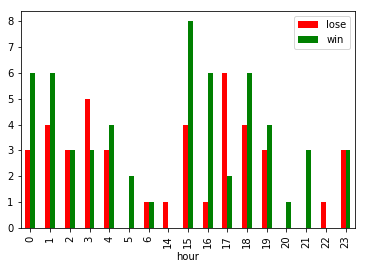

In [17]:
%matplotlib inline
hour_df.plot(kind='bar', color=['r', 'g'])

In [18]:
hour_df_rate = df.drop('wkday', 1)
hour_df_rate = hour_df_rate.groupby(hour).mean()
avg = win_rate.cnt[1] / 100
hour_df_rate['avg'] = avg
hour_df_rate = hour_df_rate.set_index('hour')
hour_df_rate.columns = ['win_rate', 'avg_rate']
hour_df_rate

,win_rate,avg_rate
hour,,
0,0.666667,0.58
1,0.600000,0.58
2,0.500000,0.58
3,0.375000,0.58
4,0.571429,0.58
5,1.000000,0.58
6,0.500000,0.58
14,0.000000,0.58
15,0.666667,0.58


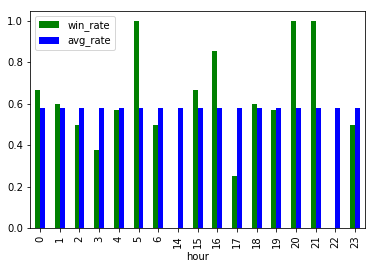

In [19]:
hour_df_rate.plot(kind='bar', color=['g', 'b'])

In [20]:
A = hour_df_rate.loc[hour_df_rate['win_rate'] > avg + 0.10].reset_index()
B = hour_df.reset_index()
best_times = pd.merge(A, B, how='left', on='hour')
best_times

,hour,win_rate,avg_rate,lose,win
0,5,1.000000,0.58,0,2
1,16,0.857143,0.58,1,6
2,20,1.000000,0.58,0,1
3,21,1.000000,0.58,0,3


In [21]:
A = hour_df_rate.loc[hour_df_rate['win_rate'] < avg - 0.10].reset_index()
B = hour_df.reset_index()
worst_times = pd.merge(A, B, how='left', on='hour')
worst_times

,hour,win_rate,avg_rate,lose,win
0,3,0.375,0.58,5,3
1,14,0.000,0.58,1,0
2,17,0.250,0.58,6,2
3,22,0.000,0.58,1,0


In [22]:
wkday_df = df.drop('hour', 1)
wkday_df = wkday_df.drop('kda', 1)
wl = pd.get_dummies(wkday_df.win)
wkday_df = pd.concat([wkday_df, wl], axis = 1)
wkday_df = wkday_df.drop('win', axis = 1)
wkday_df.columns = ['wkday', 'lose', 'win']
wkday_df = wkday_df.groupby('wkday').sum().reset_index()
wkday_df = wkday_df.sort_values(by = 'wkday')
wkday_df['weekday'] = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']
wkday_df = wkday_df.set_index('weekday')
wkday_df = wkday_df.drop('wkday', axis = 1)
wkday_df

,lose,win
weekday,,
M,5,8
Tu,1,6
W,5,4
Th,6,8
F,9,7
Sa,1,4
Su,15,21


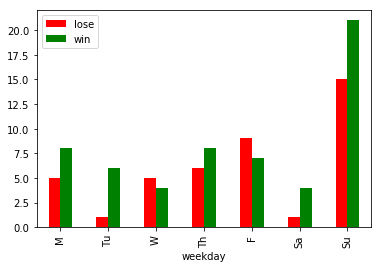

In [23]:
wkday_df.plot(kind='bar', color=['r', 'g'])

In [24]:
wkday_df_rate = df.drop('hour', 1)
wkday_df_rate = wkday_df_rate.groupby(wkday).mean()
avg = win_rate.cnt[1] / 100
wkday_df_rate['avg'] = avg
wkday_df_rate = wkday_df_rate.set_index('wkday')
wkday_df_rate.columns = ['win_rate', 'avg_rate']
wkday_df_rate['weekday'] = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']
wkday_df_rate = wkday_df_rate.set_index('weekday')
wkday_df_rate

,win_rate,avg_rate
weekday,,
M,0.615385,0.58
Tu,0.857143,0.58
W,0.444444,0.58
Th,0.571429,0.58
F,0.437500,0.58
Sa,0.800000,0.58
Su,0.583333,0.58


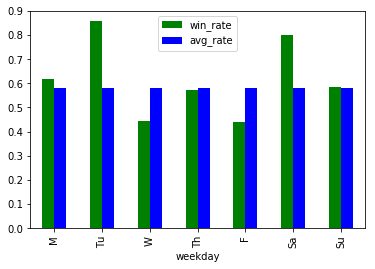

In [25]:
wkday_df_rate.plot(kind='bar', color=['g', 'b'])

In [26]:
A = wkday_df_rate.loc[wkday_df_rate['win_rate'] > avg + 0.10].reset_index()
B = wkday_df_rate.reset_index()
best_wk_times = pd.merge(A, B, how='left', on='weekday')
best_wk_times

,weekday,win_rate_x,avg_rate_x,win_rate_y,avg_rate_y
0,Tu,0.857143,0.58,0.857143,0.58
1,Sa,0.800000,0.58,0.800000,0.58


In [27]:
A = wkday_df_rate.loc[wkday_df_rate['win_rate'] < avg - 0.10].reset_index()
B = wkday_df_rate.reset_index()
worst_wk_times = pd.merge(A, B, how='left', on='weekday')
worst_wk_times

,weekday,win_rate_x,avg_rate_x,win_rate_y,avg_rate_y
0,W,0.444444,0.58,0.444444,0.58
1,F,0.437500,0.58,0.437500,0.58


# Conclusion

The best times for this player to play is 5, 16, 20, and 21. (5 AM, 4 PM, and 8-9 PM.)

They win 10% more games than their average wins.

In [28]:
best_times

,hour,win_rate,avg_rate,lose,win
0,5,1.000000,0.58,0,2
1,16,0.857143,0.58,1,6
2,20,1.000000,0.58,0,1
3,21,1.000000,0.58,0,3


The worst times for this player to play is 3, 14, 17, 22. (3 AM, 2 PM, 5 PM, and 10 PM)

They lose 10% more games than their average wins.

In [29]:
worst_times

,hour,win_rate,avg_rate,lose,win
0,3,0.375,0.58,5,3
1,14,0.000,0.58,1,0
2,17,0.250,0.58,6,2
3,22,0.000,0.58,1,0


The best days of the week for this player to play is Tuesday and Saturday.

They win 10% more games than their average wins.

In [30]:
best_wk_times

,weekday,win_rate_x,avg_rate_x,win_rate_y,avg_rate_y
0,Tu,0.857143,0.58,0.857143,0.58
1,Sa,0.800000,0.58,0.800000,0.58


The worst days of teh week for this player to play Wednesday and Friday.

They lose 10% more games than their average wins.

In [31]:
worst_wk_times

,weekday,win_rate_x,avg_rate_x,win_rate_y,avg_rate_y
0,W,0.444444,0.58,0.444444,0.58
1,F,0.437500,0.58,0.437500,0.58


## Discussion

To improve this study, here are some things that could be done.

- Larger than 100 sample size.
    - Although 100 games seems adequate for this study, more games is always better. 
    - To achieve this, we need to apply for a better API key through Riot's development portal.
    

- KDA analysis
    - I've included KDA metrics in this study but did not use it.
    - League of Legends is a team game. Thus, performance may be affected by teammate's performances.
    - So instead of win rate, we could use KDA instead.

